In [1]:
import sys
sys.path.append("..")
from functions.functions import * 

# Preprocessing

In [2]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths)

# Feature Selection

In [5]:
# selected features 
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']


# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Host Response Rate,Accommodates,Bathrooms,Bedrooms,Beds,...,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,x,y,z,text_encoding_tsne_1,text_encoding_tsne_2
27357,3,4,2.45,1,23,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208824,-0.728089,0.652900,-7.517027,-0.076676
17998,1,35,2.75,10,156,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208893,-0.728482,0.652440,-7.517027,-0.076676
11703,3,16,0.62,4,37,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,1,0,0,0,0.209660,-0.728891,0.651737,-7.517027,-0.076676
25026,1,0,0.00,10,284,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208956,-0.727793,0.653188,-7.517027,-0.076676
31283,1,0,0.00,1,43,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,1,0,0,0,0.209579,-0.728689,0.651989,-7.517027,-0.076676


# LightGBM

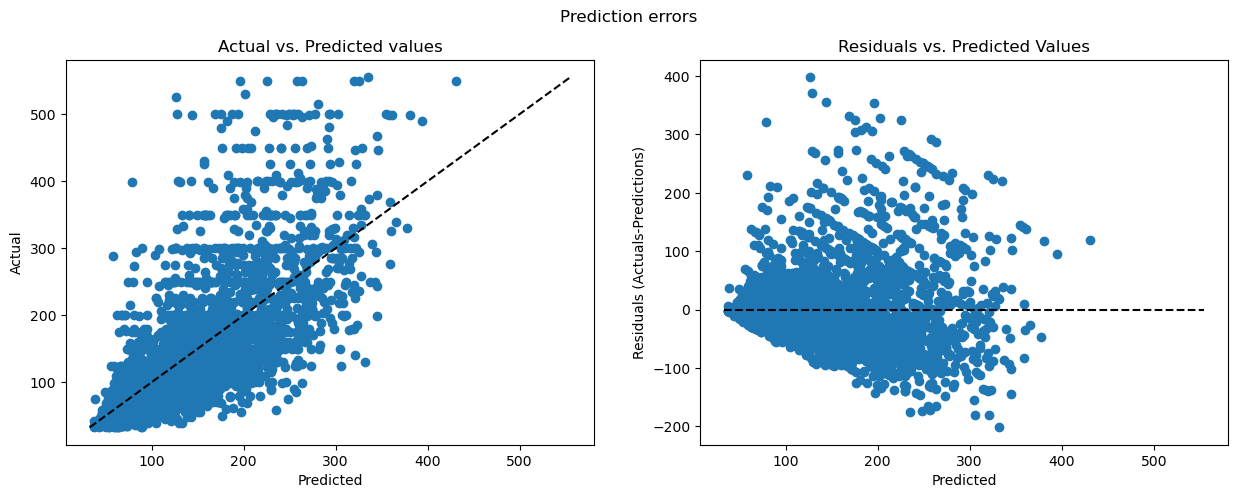

R²: 0.5547826665881491
MAE: 41.5089913992869
MSE: 3983.031060120857
RMSE: 63.111259376761424
MAPE: 0.32439762320321563
error_ratio_rmse: 0.45630466111634904
error_ratio_mae: 0.30011675318758324


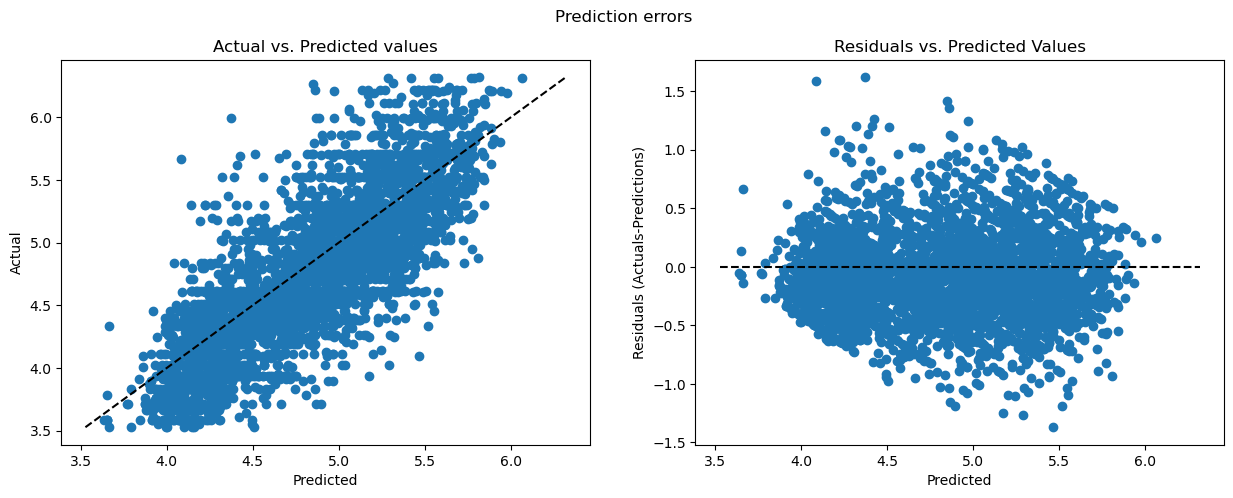

R²: 0.645707475090969
MAE: 0.2911629132762393
MSE: 0.137688837725636
RMSE: 0.37106446572750135
MAPE: 0.0627116337716528
error_ratio_rmse: 0.07831458585789038
error_ratio_mae: 0.061451055211389764


In [9]:
model_init = LGBMRegressor(objective = 'regression', metric = 'rmse').fit(X_train_np, y_train_np)
y_pred = np.maximum(0,model_init.predict(X_test_np))

# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

#### Model Tuning

In [12]:
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'reg_alpha' : hp.quniform('reg_alpha', 0,280,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,150),
        'learning_rate' : hp.uniform('learning_rate', 0.001,0.1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'colsample_bynode' : hp.uniform('colsample_bynode', 0.5,1),
        'subsample' : hp.uniform('subsample', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 400, 1),
        'seed': hp.quniform('seed', 0, 400, 1)
    }

def objective(space):
    mod=LGBMRegressor(
                          n_estimators =int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          reg_alpha = space['reg_alpha'],
                          reg_lambda = space['reg_lambda'],
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=space['colsample_bytree'],
                          colsample_bynode=space['colsample_bynode'],
                          subsample=space['subsample'],
                          learning_rate=space['learning_rate'],
                          seed = int(space['seed']),
                          objective = 'regression',
                          metric='rmse'
                       )

    evaluation = [( X_train_np, y_train_np), ( X_val_np, y_val_np)]
    
    mod.set_params(early_stopping_round=10)
    mod.fit(X_train_np, y_train_np,eval_set=evaluation,verbose=False)

    y_pred = mod.predict(X_test_np)
    score = scores(y_test_np, y_pred)['RMSE']
    print ("SCORE:", score)

    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5305836656423163                                                                                                 
MAE: 42.852620310476595                                                                                                
MSE: 4199.521670790735                                                                                                 
RMSE: 64.8037164890312                                                                                                 
MAPE: 0.3366091307506917                                                                                               
error_ratio_rmse: 0.46854140106884923                                                                                  
error_ratio_mae: 0.3098314085603502                                                                                    
SCORE:                                                                                                                 
64.8037164890312                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.4534069684631393                                                                                                 
MAE: 47.96471760204437                                                                                                 
MSE: 4889.9646497882395                                                                                                
RMSE: 69.92828218816933                                                                                                
MAPE: 0.4300154829699118                                                                                               
error_ratio_rmse: 0.5055928438352522                                                                                   
error_ratio_mae: 0.3467927027138553                                                                                    
SCORE:                                                                                                                 
69.92828218816933                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.550009429628249                                                                                                  
MAE: 41.83238222095576                                                                                                 
MSE: 4025.7336901440503                                                                                                
RMSE: 63.44866972714282                                                                                                
MAPE: 0.3243239560357004                                                                                               
error_ratio_rmse: 0.4587441927800861                                                                                   
error_ratio_mae: 0.3024549213805013                                                                                    
SCORE:                                                                                                                 
63.44866972714282                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.501472056399191                                                                                                  
MAE: 44.81870210345406                                                                                                 
MSE: 4459.9617640298875                                                                                                
RMSE: 66.7829451584002                                                                                                 
MAPE: 0.3777302370633358                                                                                               
error_ratio_rmse: 0.48285154598065755                                                                                  
error_ratio_mae: 0.3240464994194298                                                                                    
SCORE:                                                                                                                 
66.7829451584002                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5612884429697476                                                                                                 
MAE: 41.3424963119977                                                                                                  
MSE: 3924.828677928031                                                                                                 
RMSE: 62.64845311680114                                                                                                
MAPE: 0.32141444850394235                                                                                              
error_ratio_rmse: 0.4529584966490391                                                                                   
error_ratio_mae: 0.2989129666503903                                                                                    
SCORE:                                                                                                                 
62.64845311680114                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5579884628409078                                                                                                 
MAE: 41.34131536894019                                                                                                 
MSE: 3954.3511658559482                                                                                                
RMSE: 62.88363193912982                                                                                                
MAPE: 0.32109129716062734                                                                                              
error_ratio_rmse: 0.45465887775193853                                                                                  
error_ratio_mae: 0.2989044282401767                                                                                    
SCORE:                                                                                                                 
62.88363193912982                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.4927853417756347                                                                                                 
MAE: 45.19100640540922                                                                                                 
MSE: 4537.675391868416                                                                                                 
RMSE: 67.36226979451045                                                                                                
MAPE: 0.3789361283424355                                                                                               
error_ratio_rmse: 0.4870401572422161                                                                                   
error_ratio_mae: 0.3267383200234465                                                                                    
SCORE:                                                                                                                 
67.36226979451045                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5356309157648538                                                                                                 
MAE: 42.621639639341254                                                                                                
MSE: 4154.367647131758                                                                                                 
RMSE: 64.45438423514538                                                                                                
MAPE: 0.33352273926802417                                                                                              
error_ratio_rmse: 0.46601567210542                                                                                     
error_ratio_mae: 0.30816138077279426                                                                                   
SCORE:                                                                                                                 
64.45438423514538                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.522575531360695                                                                                                  
MAE: 43.53288210308687                                                                                                 
MSE: 4271.164540875962                                                                                                 
RMSE: 65.35414708246113                                                                                                
MAPE: 0.34339234295352683                                                                                              
error_ratio_rmse: 0.47252110370643585                                                                                  
error_ratio_mae: 0.3147498118660799                                                                                    
SCORE:                                                                                                                 
65.35414708246113                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5556192522672364                                                                                                 
MAE: 41.56677735374043                                                                                                 
MSE: 3975.5467451712984                                                                                                
RMSE: 63.0519368867547                                                                                                 
MAPE: 0.32176803427470024                                                                                              
error_ratio_rmse: 0.4558757498734677                                                                                   
error_ratio_mae: 0.30053455502872206                                                                                   
SCORE:                                                                                                                 
63.0519368867547                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5509280794923682                                                                                                 
MAE: 41.81995622315922                                                                                                 
MSE: 4017.515207467012                                                                                                 
RMSE: 63.38387182451867                                                                                                
MAPE: 0.3262553439885714                                                                                               
error_ratio_rmse: 0.45827569341420515                                                                                  
error_ratio_mae: 0.3023650793971599                                                                                    
SCORE:                                                                                                                 
63.38387182451867                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5566031834359424                                                                                                 
MAE: 41.4812629209792                                                                                                  
MSE: 3966.744238817954                                                                                                 
RMSE: 62.982094589001676                                                                                               
MAPE: 0.32232934220383347                                                                                              
error_ratio_rmse: 0.45537077871107134                                                                                  
error_ratio_mae: 0.29991627178343416                                                                                   
SCORE:                                                                                                                 
62.982094589001676                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.40394756146610533                                                                                                
MAE: 50.54909720769394                                                                                                 
MSE: 5332.44147964273                                                                                                  
RMSE: 73.02356797392696                                                                                                
MAPE: 0.45991901931885243                                                                                              
error_ratio_rmse: 0.527972263062124                                                                                    
error_ratio_mae: 0.36547818723432673                                                                                   
SCORE:                                                                                                                 
73.02356797392696                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.42061072663599275                                                                                                
MAE: 49.65771340998366                                                                                                 
MSE: 5183.368432726585                                                                                                 
RMSE: 71.99561398256553                                                                                                
MAPE: 0.4516628231697773                                                                                               
error_ratio_rmse: 0.5205399886581039                                                                                   
error_ratio_mae: 0.3590333375235861                                                                                    
SCORE:                                                                                                                 
71.99561398256553                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5504146875252718                                                                                                 
MAE: 41.90810517516893                                                                                                 
MSE: 4022.1081466845644                                                                                                
RMSE: 63.42009261018597                                                                                                
MAPE: 0.32607380787322454                                                                                              
error_ratio_rmse: 0.45853757558059666                                                                                  
error_ratio_mae: 0.3030024106447338                                                                                    
SCORE:                                                                                                                 
63.42009261018597                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.46848934864711966                                                                                                
MAE: 46.31669584861908                                                                                                 
MSE: 4755.0337200488675                                                                                                
RMSE: 68.95675253409827                                                                                                
MAPE: 0.39022072554382575                                                                                              
error_ratio_rmse: 0.4985685265590133                                                                                   
error_ratio_mae: 0.3348772376267175                                                                                    
SCORE:                                                                                                                 
68.95675253409827                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.43634844242160997                                                                                                
MAE: 48.98359056354912                                                                                                 
MSE: 5042.574698778491                                                                                                 
RMSE: 71.01108856212875                                                                                                
MAPE: 0.44513290016767854                                                                                              
error_ratio_rmse: 0.5134217098791788                                                                                   
error_ratio_mae: 0.3541593197963093                                                                                    
SCORE:                                                                                                                 
71.01108856212875                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.2741878805399979                                                                                                 
MAE: 58.44949038618224                                                                                                 
MSE: 6493.305625518099                                                                                                 
RMSE: 80.58105003980836                                                                                                
MAPE: 0.5743333815526223                                                                                               
error_ratio_rmse: 0.582614086518347                                                                                    
error_ratio_mae: 0.4225993137590722                                                                                    
SCORE:                                                                                                                 
80.58105003980836                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5428407141688739                                                                                                 
MAE: 42.24563935555336                                                                                                 
MSE: 4089.86689923779                                                                                                  
RMSE: 63.95206720066045                                                                                                
MAPE: 0.33122235764890956                                                                                              
error_ratio_rmse: 0.462383838317644                                                                                    
error_ratio_mae: 0.30544283761951563                                                                                   
SCORE:                                                                                                                 
63.95206720066045                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5559771046729641                                                                                                 
MAE: 41.46441482205416                                                                                                 
MSE: 3972.345303672986                                                                                                 
RMSE: 63.026544437030545                                                                                               
MAPE: 0.3217340451710118                                                                                               
error_ratio_rmse: 0.4556921583355913                                                                                   
error_ratio_mae: 0.2997944572903253                                                                                    
SCORE:                                                                                                                 
63.026544437030545                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5470384742976945                                                                                                 
MAE: 41.99060569805163                                                                                                 
MSE: 4052.312635912282                                                                                                 
RMSE: 63.65777749742982                                                                                                
MAPE: 0.3277037529683064                                                                                               
error_ratio_rmse: 0.460256075940078                                                                                    
error_ratio_mae: 0.303598902831828                                                                                     
SCORE:                                                                                                                 
63.65777749742982                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5610878729270532                                                                                                 
MAE: 41.100984211597236                                                                                                
MSE: 3926.6230301462147                                                                                                
RMSE: 62.66277228264175                                                                                                
MAPE: 0.317668932422085                                                                                                
error_ratio_rmse: 0.4530620265449862                                                                                   
error_ratio_mae: 0.29716679491784986                                                                                   
SCORE:                                                                                                                 
62.66277228264175                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5612801988188953                                                                                                 
MAE: 41.30506180995285                                                                                                 
MSE: 3924.9024322642717                                                                                                
RMSE: 62.64904175056688                                                                                                
MAPE: 0.3208750038409938                                                                                               
error_ratio_rmse: 0.4529627525668206                                                                                   
error_ratio_mae: 0.2986423091173555                                                                                    
SCORE:                                                                                                                 
62.64904175056688                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5609619565430787                                                                                                 
MAE: 41.24640880648282                                                                                                 
MSE: 3927.749511149336                                                                                                 
RMSE: 62.671760077002276                                                                                               
MAPE: 0.3189777405054292                                                                                               
error_ratio_rmse: 0.45312700975876397                                                                                  
error_ratio_mae: 0.29821823837092853                                                                                   
SCORE:                                                                                                                 
62.671760077002276                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5569498327740612                                                                                                 
MAE: 41.461924117464804                                                                                                
MSE: 3963.6430229014113                                                                                                
RMSE: 62.95746995314703                                                                                                
MAPE: 0.3201920151914275                                                                                               
error_ratio_rmse: 0.45519273859224424                                                                                  
error_ratio_mae: 0.29977644909139517                                                                                   
SCORE:                                                                                                                 
62.95746995314703                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5514855266880361                                                                                                 
MAE: 41.80049106976403                                                                                                 
MSE: 4012.5281386174966                                                                                                
RMSE: 63.34451940474011                                                                                                
MAPE: 0.32582682264184665                                                                                              
error_ratio_rmse: 0.4579911690242866                                                                                   
error_ratio_mae: 0.3022243431749504                                                                                    
SCORE:                                                                                                                 
63.34451940474011                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5603175551507481                                                                                                 
MAE: 41.266142155883635                                                                                                
MSE: 3933.514495053194                                                                                                 
RMSE: 62.71773668630903                                                                                                
MAPE: 0.3191467145965398                                                                                               
error_ratio_rmse: 0.4534594281154276                                                                                   
error_ratio_mae: 0.2983609136938416                                                                                    
SCORE:                                                                                                                 
62.71773668630903                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.558219620020579                                                                                                  
MAE: 41.409075140520265                                                                                                
MSE: 3952.283173086338                                                                                                 
RMSE: 62.86718677566492                                                                                                
MAPE: 0.32000264016886504                                                                                              
error_ratio_rmse: 0.45453997654768497                                                                                  
error_ratio_mae: 0.29939434239992413                                                                                   
SCORE:                                                                                                                 
62.86718677566492                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5583080810396188                                                                                                 
MAE: 41.34695292827714                                                                                                 
MSE: 3951.4917776037196                                                                                                
RMSE: 62.86089227495677                                                                                                
MAPE: 0.31896820351092375                                                                                              
error_ratio_rmse: 0.4544944662846845                                                                                   
error_ratio_mae: 0.29894518871030795                                                                                   
SCORE:                                                                                                                 
62.86089227495677                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.12213869357840035                                                                                                
MAE: 66.39542367642396                                                                                                 
MSE: 7853.57753967095                                                                                                  
RMSE: 88.62041265798162                                                                                                
MAPE: 0.6747591196477406                                                                                               
error_ratio_rmse: 0.6407399846750832                                                                                   
error_ratio_mae: 0.48004970269223823                                                                                   
SCORE:                                                                                                                 
88.62041265798162                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5390786631106337                                                                                                 
MAE: 42.3626829696843                                                                                                  
MSE: 4123.523194916805                                                                                                 
RMSE: 64.2146649521494                                                                                                 
MAPE: 0.3321934361093927                                                                                               
error_ratio_rmse: 0.46428246273405366                                                                                  
error_ratio_mae: 0.30628908196971977                                                                                   
SCORE:                                                                                                                 
64.2146649521494                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5543844884956581                                                                                                 
MAE: 41.490140752412735                                                                                                
MSE: 3986.5932657917315                                                                                                
RMSE: 63.13947470316594                                                                                                
MAPE: 0.3214787788078769                                                                                               
error_ratio_rmse: 0.45650866251135275                                                                                  
error_ratio_mae: 0.29998045994738043                                                                                   
SCORE:                                                                                                                 
63.13947470316594                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5526066406381406                                                                                                 
MAE: 41.714714275152666                                                                                                
MSE: 4002.498359114123                                                                                                 
RMSE: 63.265301383255284                                                                                               
MAPE: 0.3245865668392102                                                                                               
error_ratio_rmse: 0.45741840985571813                                                                                  
error_ratio_mae: 0.30160416301085125                                                                                   
SCORE:                                                                                                                 
63.265301383255284                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5557968657315093                                                                                                 
MAE: 41.5173594485584                                                                                                  
MSE: 3973.957768525952                                                                                                 
RMSE: 63.039335089497506                                                                                               
MAPE: 0.322421185016968                                                                                                
error_ratio_rmse: 0.45578463683145765                                                                                  
error_ratio_mae: 0.3001772555436564                                                                                    
SCORE:                                                                                                                 
63.039335089497506                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5572252433374381                                                                                                 
MAE: 41.44178846657668                                                                                                 
MSE: 3961.179127752027                                                                                                 
RMSE: 62.93789897789747                                                                                                
MAPE: 0.3198626747908412                                                                                               
error_ratio_rmse: 0.45505123726083113                                                                                  
error_ratio_mae: 0.29963086506335335                                                                                   
SCORE:                                                                                                                 
62.93789897789747                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5626350921115416                                                                                                 
MAE: 41.109549050292685                                                                                                
MSE: 3912.7812014343676                                                                                                
RMSE: 62.55222778953894                                                                                                
MAPE: 0.317904690130294                                                                                                
error_ratio_rmse: 0.4522627718959476                                                                                   
error_ratio_mae: 0.29722872009343715                                                                                   
SCORE:                                                                                                                 
62.55222778953894                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5578891389040221                                                                                                 
MAE: 41.46237572075482                                                                                                 
MSE: 3955.2397438513217                                                                                                
RMSE: 62.8906967989012                                                                                                 
MAPE: 0.32124250527203607                                                                                              
error_ratio_rmse: 0.45470995783615253                                                                                  
error_ratio_mae: 0.29977971425656924                                                                                   
SCORE:                                                                                                                 
62.8906967989012                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5537626122130408                                                                                                 
MAE: 41.5572138413792                                                                                                  
MSE: 3992.1567341550035                                                                                                
RMSE: 63.1835163167974                                                                                                 
MAPE: 0.32105647984417546                                                                                              
error_ratio_rmse: 0.45682709053483983                                                                                  
error_ratio_mae: 0.30046540928024285                                                                                   
SCORE:                                                                                                                 
63.1835163167974                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5607657551221081                                                                                                 
MAE: 41.24735532205233                                                                                                 
MSE: 3929.504780531542                                                                                                 
RMSE: 62.68576218354166                                                                                                
MAPE: 0.3186597556658629                                                                                               
error_ratio_rmse: 0.4532282472644399                                                                                   
error_ratio_mae: 0.2982250818323085                                                                                    
SCORE:                                                                                                                 
62.68576218354166                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5599629167726798                                                                                                 
MAE: 41.25345217477024                                                                                                 
MSE: 3936.687183016918                                                                                                 
RMSE: 62.743024975027446                                                                                               
MAPE: 0.3197399205007694                                                                                               
error_ratio_rmse: 0.45364226655230594                                                                                  
error_ratio_mae: 0.29826916306822104                                                                                   
SCORE:                                                                                                                 
62.743024975027446                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.535372742525841                                                                                                  
MAE: 42.66724190601601                                                                                                 
MSE: 4156.677332655454                                                                                                 
RMSE: 64.47229895587293                                                                                                
MAPE: 0.33358966274077345                                                                                              
error_ratio_rmse: 0.4661451984474912                                                                                   
error_ratio_mae: 0.30849109257139645                                                                                   
SCORE:                                                                                                                 
64.47229895587293                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5587994764923785                                                                                                 
MAE: 41.33286065967144                                                                                                 
MSE: 3947.0956249738465                                                                                                
RMSE: 62.8259152338734                                                                                                 
MAPE: 0.3207466265340983                                                                                               
error_ratio_rmse: 0.45424157659374803                                                                                  
error_ratio_mae: 0.2988432993182409                                                                                    
SCORE:                                                                                                                 
62.8259152338734                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.48591360799528194                                                                                                
MAE: 45.21782941011238                                                                                                 
MSE: 4599.151724953381                                                                                                 
RMSE: 67.81704597631322                                                                                                
MAPE: 0.3685587217399057                                                                                               
error_ratio_rmse: 0.49032826293952864                                                                                  
error_ratio_mae: 0.3269322547062918                                                                                    
SCORE:                                                                                                                 
67.81704597631322                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5338610375590231                                                                                                 
MAE: 42.73099617463864                                                                                                 
MSE: 4170.20144185945                                                                                                  
RMSE: 64.57709688317871                                                                                                
MAPE: 0.33633510684962015                                                                                              
error_ratio_rmse: 0.4669029044919782                                                                                   
error_ratio_mae: 0.3089520462938519                                                                                    
SCORE:                                                                                                                 
64.57709688317871                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5497684915021497                                                                                                 
MAE: 41.81860278617256                                                                                                 
MSE: 4027.8891858262755                                                                                                
RMSE: 63.465653591736334                                                                                               
MAPE: 0.3246637297439524                                                                                               
error_ratio_rmse: 0.45886698888104055                                                                                  
error_ratio_mae: 0.3023552938278076                                                                                    
SCORE:                                                                                                                 
63.465653591736334                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5618737282994403                                                                                                 
MAE: 41.18267847018031                                                                                                 
MSE: 3919.592561828655                                                                                                 
RMSE: 62.606649501699536                                                                                               
MAPE: 0.3192735091411775                                                                                               
error_ratio_rmse: 0.45265624971860624                                                                                  
error_ratio_mae: 0.2977574576830367                                                                                    
SCORE:                                                                                                                 
62.606649501699536                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5518462709981384                                                                                                 
MAE: 41.669173923785635                                                                                                
MSE: 4009.3008253840057                                                                                                
RMSE: 63.319039991016965                                                                                               
MAPE: 0.32346078966917013                                                                                              
error_ratio_rmse: 0.4578069487225655                                                                                   
error_ratio_mae: 0.3012748988699854                                                                                    
SCORE:                                                                                                                 
63.319039991016965                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5575394329505712                                                                                                 
MAE: 41.382928177073595                                                                                                
MSE: 3958.3683050504787                                                                                                
RMSE: 62.91556488700136                                                                                                
MAPE: 0.32065784947922454                                                                                              
error_ratio_rmse: 0.45488975815427657                                                                                  
error_ratio_mae: 0.29920529560522263                                                                                   
SCORE:                                                                                                                 
62.91556488700136                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.559421293469105                                                                                                  
MAE: 41.340682191630236                                                                                                
MSE: 3941.5326871766315                                                                                                
RMSE: 62.7816269873331                                                                                                 
MAPE: 0.3206847865655769                                                                                               
error_ratio_rmse: 0.45392136537425126                                                                                  
error_ratio_mae: 0.298899850265332                                                                                     
SCORE:                                                                                                                 
62.7816269873331                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5493740981781747                                                                                                 
MAE: 41.8008922302416                                                                                                  
MSE: 4031.417531965133                                                                                                 
RMSE: 63.49344479523168                                                                                                
MAPE: 0.324062241181619                                                                                                
error_ratio_rmse: 0.4590679237984893                                                                                   
error_ratio_mae: 0.3022272436303933                                                                                    
SCORE:                                                                                                                 
63.49344479523168                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5519823072491511                                                                                                 
MAE: 41.665446104341505                                                                                                
MSE: 4008.0838093955817                                                                                                
RMSE: 63.309429071786624                                                                                               
MAPE: 0.32320214291409294                                                                                              
error_ratio_rmse: 0.45773746021471884                                                                                  
error_ratio_mae: 0.3012479461296193                                                                                    
SCORE:                                                                                                                 
63.309429071786624                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5462729184524648                                                                                                 
MAE: 41.95890755770882                                                                                                 
MSE: 4059.1614993346466                                                                                                
RMSE: 63.711549183288945                                                                                               
MAPE: 0.32635513458059123                                                                                              
error_ratio_rmse: 0.4606448539669452                                                                                   
error_ratio_mae: 0.30336972012607977                                                                                   
SCORE:                                                                                                                 
63.711549183288945                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5602523047290651                                                                                                 
MAE: 41.24069993399925                                                                                                 
MSE: 3934.0982424429417                                                                                                
RMSE: 62.72239028005025                                                                                                
MAPE: 0.32001571922394817                                                                                              
error_ratio_rmse: 0.4534930743544035                                                                                   
error_ratio_mae: 0.2981769622951586                                                                                    
SCORE:                                                                                                                 
62.72239028005025                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5588672058402624                                                                                                 
MAE: 41.245488156921425                                                                                                
MSE: 3946.489700460001                                                                                                 
RMSE: 62.82109279899547                                                                                                
MAPE: 0.3186987251901615                                                                                               
error_ratio_rmse: 0.4542067096059164                                                                                   
error_ratio_mae: 0.2982115819249906                                                                                    
SCORE:                                                                                                                 
62.82109279899547                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5530979453991125                                                                                                 
MAE: 41.60979332615591                                                                                                 
MSE: 3998.103017836774                                                                                                 
RMSE: 63.23055446409413                                                                                                
MAPE: 0.3226006992024777                                                                                               
error_ratio_rmse: 0.457167183983675                                                                                    
error_ratio_mae: 0.30084556749954694                                                                                   
SCORE:                                                                                                                 
63.23055446409413                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5639788483266531                                                                                                 
MAE: 41.00375662731669                                                                                                 
MSE: 3900.759605821718                                                                                                 
RMSE: 62.456061401770434                                                                                               
MAPE: 0.31686306475314924                                                                                              
error_ratio_rmse: 0.4515674732849735                                                                                   
error_ratio_mae: 0.2964638236836451                                                                                    
SCORE:                                                                                                                 
62.456061401770434                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.566489795362622                                                                                                  
MAE: 40.98329433413874                                                                                                 
MSE: 3878.296014932432                                                                                                 
RMSE: 62.27596659171524                                                                                                
MAPE: 0.31703133688804913                                                                                              
error_ratio_rmse: 0.4502653585421752                                                                                   
error_ratio_mae: 0.29631587797876724                                                                                   
SCORE:                                                                                                                 
62.27596659171524                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5521510372726346                                                                                                 
MAE: 41.64172784665253                                                                                                 
MSE: 4006.574306341962                                                                                                 
RMSE: 63.29750632009102                                                                                                
MAPE: 0.32302617591613525                                                                                              
error_ratio_rmse: 0.4576512567824666                                                                                   
error_ratio_mae: 0.30107645927221993                                                                                   
SCORE:                                                                                                                 
63.29750632009102                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5538899909515032                                                                                                 
MAE: 41.56411168928616                                                                                                 
MSE: 3991.0171705450102                                                                                                
RMSE: 63.174497786250825                                                                                               
MAPE: 0.32097353701280695                                                                                              
error_ratio_rmse: 0.4567618850934422                                                                                   
error_ratio_mae: 0.300515281841537                                                                                     
SCORE:                                                                                                                 
63.174497786250825                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5494259838788015                                                                                                 
MAE: 42.00975153610619                                                                                                 
MSE: 4030.95334887597                                                                                                  
RMSE: 63.4897893277019                                                                                                 
MAPE: 0.3273505077753029                                                                                               
error_ratio_rmse: 0.45904149417422146                                                                                  
error_ratio_mae: 0.30373733035223477                                                                                   
SCORE:                                                                                                                 
63.4897893277019                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.3068311147727978                                                                                                 
MAE: 56.755535128750104                                                                                                
MSE: 6201.270688657795                                                                                                 
RMSE: 78.7481472077775                                                                                                 
MAPE: 0.5522977136157143                                                                                               
error_ratio_rmse: 0.5693619011890046                                                                                   
error_ratio_mae: 0.41035174197359386                                                                                   
SCORE:                                                                                                                 
78.7481472077775                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.53762702136395                                                                                                   
MAE: 42.51368971934121                                                                                                 
MSE: 4136.509962796887                                                                                                 
RMSE: 64.31570541319505                                                                                                
MAPE: 0.3347262593438466                                                                                               
error_ratio_rmse: 0.46501300168687715                                                                                  
error_ratio_mae: 0.3073808853089168                                                                                    
SCORE:                                                                                                                 
64.31570541319505                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5590311810966384                                                                                                 
MAE: 41.4340126542849                                                                                                  
MSE: 3945.0227348002586                                                                                                
RMSE: 62.80941597245001                                                                                                
MAPE: 0.3209848976806692                                                                                               
error_ratio_rmse: 0.4541222842524635                                                                                   
error_ratio_mae: 0.2995746446768843                                                                                    
SCORE:                                                                                                                 
62.80941597245001                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5536622978627439                                                                                                 
MAE: 41.66779314472716                                                                                                 
MSE: 3993.0541726485744                                                                                                
RMSE: 63.19061775808632                                                                                                
MAPE: 0.3230896299213338                                                                                               
error_ratio_rmse: 0.4568784351093702                                                                                   
error_ratio_mae: 0.3012649156130107                                                                                    
SCORE:                                                                                                                 
63.19061775808632                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5589345108728335                                                                                                 
MAE: 41.34582416392823                                                                                                 
MSE: 3945.887571982255                                                                                                 
RMSE: 62.81630020927892                                                                                                
MAPE: 0.3210614036401508                                                                                               
error_ratio_rmse: 0.4541720584034515                                                                                   
error_ratio_mae: 0.2989370275606368                                                                                    
SCORE:                                                                                                                 
62.81630020927892                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.561886558467867                                                                                                  
MAE: 41.09535571159876                                                                                                 
MSE: 3919.4777797761267                                                                                                
RMSE: 62.605732802804305                                                                                               
MAPE: 0.31791021835983263                                                                                              
error_ratio_rmse: 0.45264962183662666                                                                                  
error_ratio_mae: 0.297126099948208                                                                                     
SCORE:                                                                                                                 
62.605732802804305                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5603976571693405                                                                                                 
MAE: 41.207364699461735                                                                                                
MSE: 3932.797881381424                                                                                                 
RMSE: 62.712023419607696                                                                                               
MAPE: 0.31858826435012666                                                                                              
error_ratio_rmse: 0.45341812026874917                                                                                  
error_ratio_mae: 0.29793594313234856                                                                                   
SCORE:                                                                                                                 
62.712023419607696                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5642944983832736                                                                                                 
MAE: 41.159570227002654                                                                                                
MSE: 3897.935717609608                                                                                                 
RMSE: 62.43345030998694                                                                                                
MAPE: 0.3202639255066883                                                                                               
error_ratio_rmse: 0.45140399141698945                                                                                  
error_ratio_mae: 0.2975903813296838                                                                                    
SCORE:                                                                                                                 
62.43345030998694                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.560243108197748                                                                                                  
MAE: 41.291634577774104                                                                                                
MSE: 3934.180517024662                                                                                                 
RMSE: 62.723046139554334                                                                                               
MAPE: 0.3203894920937552                                                                                               
error_ratio_rmse: 0.45349781632519776                                                                                  
error_ratio_mae: 0.2985452280467263                                                                                    
SCORE:                                                                                                                 
62.723046139554334                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5587081116643922                                                                                                 
MAE: 41.41169308810142                                                                                                 
MSE: 3947.912998693067                                                                                                 
RMSE: 62.832419965278014                                                                                               
MAPE: 0.3222409986400032                                                                                               
error_ratio_rmse: 0.45428860685884725                                                                                  
error_ratio_mae: 0.29941327058636247                                                                                   
SCORE:                                                                                                                 
62.832419965278014                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.555274429127989                                                                                                  
MAE: 41.577265546806224                                                                                                
MSE: 3978.6316234336646                                                                                                
RMSE: 63.07639513664097                                                                                                
MAPE: 0.3226696131358329                                                                                               
error_ratio_rmse: 0.4560525869947051                                                                                   
error_ratio_mae: 0.3006103863689595                                                                                    
SCORE:                                                                                                                 
63.07639513664097                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5615922872972783                                                                                                 
MAE: 41.27166342101905                                                                                                 
MSE: 3922.110406865398                                                                                                 
RMSE: 62.62675472084912                                                                                                
MAPE: 0.3200059351235132                                                                                               
error_ratio_rmse: 0.4528016137202332                                                                                   
error_ratio_mae: 0.2984008333379975                                                                                    
SCORE:                                                                                                                 
62.62675472084912                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5600612213341503                                                                                                 
MAE: 41.330708561867326                                                                                                
MSE: 3935.807724621424                                                                                                 
RMSE: 62.73601616791924                                                                                                
MAPE: 0.3192117335684719                                                                                               
error_ratio_rmse: 0.4535915917379555                                                                                   
error_ratio_mae: 0.298827739301393                                                                                     
SCORE:                                                                                                                 
62.73601616791924                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5617039909087149                                                                                                 
MAE: 41.06016311154791                                                                                                 
MSE: 3921.1110770538867                                                                                                
RMSE: 62.618775754991304                                                                                               
MAPE: 0.3183445459856679                                                                                               
error_ratio_rmse: 0.4527439245004685                                                                                   
error_ratio_mae: 0.29687165173090746                                                                                   
SCORE:                                                                                                                 
62.618775754991304                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5622899796686539                                                                                                 
MAE: 41.17258229694117                                                                                                 
MSE: 3915.868667882994                                                                                                 
RMSE: 62.576902031684135                                                                                               
MAPE: 0.32048938211274164                                                                                              
error_ratio_rmse: 0.4524411706763166                                                                                   
error_ratio_mae: 0.2976844607098507                                                                                    
SCORE:                                                                                                                 
62.576902031684135                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.561084672759552                                                                                                  
MAE: 41.16578623425099                                                                                                 
MSE: 3926.6516596841916                                                                                                
RMSE: 62.663000723586414                                                                                               
MAPE: 0.3182909609801206                                                                                               
error_ratio_rmse: 0.45306367821013865                                                                                  
error_ratio_mae: 0.2976353240722144                                                                                    
SCORE:                                                                                                                 
62.663000723586414                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5597733006582413                                                                                                 
MAE: 41.26100707267049                                                                                                 
MSE: 3938.3835385193424                                                                                                
RMSE: 62.75654179859931                                                                                                
MAPE: 0.32073219659435337                                                                                              
error_ratio_rmse: 0.4537399953832663                                                                                   
error_ratio_mae: 0.2983237862077398                                                                                    
SCORE:                                                                                                                 
62.75654179859931                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.3939397656330502                                                                                                 
MAE: 51.81881803471876                                                                                                 
MSE: 5421.973846545284                                                                                                 
RMSE: 73.63405357947696                                                                                                
MAPE: 0.4891162607018972                                                                                               
error_ratio_rmse: 0.5323861731965092                                                                                   
error_ratio_mae: 0.3746584751482337                                                                                    
SCORE:                                                                                                                 
73.63405357947696                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5277694846900913                                                                                                 
MAE: 43.05902516412258                                                                                                 
MSE: 4224.69807184326                                                                                                  
RMSE: 64.99767743422268                                                                                                
MAPE: 0.34712621010773237                                                                                              
error_ratio_rmse: 0.46994377022198314                                                                                  
error_ratio_mae: 0.31132374919379313                                                                                   
SCORE:                                                                                                                 
64.99767743422268                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5608279991837264                                                                                                 
MAE: 41.22232103599282                                                                                                 
MSE: 3928.9479288276043                                                                                                
RMSE: 62.68132041388092                                                                                                
MAPE: 0.3186951763794585                                                                                               
error_ratio_rmse: 0.4531961325479881                                                                                   
error_ratio_mae: 0.2980440798759305                                                                                    
SCORE:                                                                                                                 
62.68132041388092                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5596509672800264                                                                                                 
MAE: 41.114199137150486                                                                                                
MSE: 3939.477965012995                                                                                                 
RMSE: 62.76526081370964                                                                                                
MAPE: 0.3176340875104211                                                                                               
error_ratio_rmse: 0.4538030352793875                                                                                   
error_ratio_mae: 0.29726234097707604                                                                                   
SCORE:                                                                                                                 
62.76526081370964                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5591867584630523                                                                                                 
MAE: 41.31819279065055                                                                                                 
MSE: 3943.630898867166                                                                                                 
RMSE: 62.79833515999581                                                                                                
MAPE: 0.3207119870706505                                                                                               
error_ratio_rmse: 0.45404216817774495                                                                                  
error_ratio_mae: 0.2987372482416347                                                                                    
SCORE:                                                                                                                 
62.79833515999581                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.4890500801716823                                                                                                 
MAE: 45.40578266442996                                                                                                 
MSE: 4571.092022061601                                                                                                 
RMSE: 67.60985151634043                                                                                                
MAPE: 0.38664455492065886                                                                                              
error_ratio_rmse: 0.48883021332402876                                                                                  
error_ratio_mae: 0.3282911872781345                                                                                    
SCORE:                                                                                                                 
67.60985151634043                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.559955220958668                                                                                                  
MAE: 41.23917370390781                                                                                                 
MSE: 3936.7560317879365                                                                                                
RMSE: 62.74357362939998                                                                                                
MAPE: 0.3198086998724311                                                                                               
error_ratio_rmse: 0.4536462334125778                                                                                   
error_ratio_mae: 0.2981659274035792                                                                                    
SCORE:                                                                                                                 
62.74357362939998                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5513836456823236                                                                                                 
MAE: 41.748813433499905                                                                                                
MSE: 4013.4395928214017                                                                                                
RMSE: 63.35171341661883                                                                                                
MAPE: 0.3236427272771237                                                                                               
error_ratio_rmse: 0.4580431828992243                                                                                   
error_ratio_mae: 0.30185070546694615                                                                                   
SCORE:                                                                                                                 
63.35171341661883                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.553453972547586                                                                                                  
MAE: 41.67142115805291                                                                                                 
MSE: 3994.9179055686845                                                                                                
RMSE: 63.20536294942609                                                                                                
MAPE: 0.32361249190205055                                                                                              
error_ratio_rmse: 0.45698504523890704                                                                                  
error_ratio_mae: 0.30129114673892193                                                                                   
SCORE:                                                                                                                 
63.20536294942609                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.55043715479864                                                                                                   
MAE: 41.7972700723444                                                                                                  
MSE: 4021.9071485630943                                                                                                
RMSE: 63.41850793390755                                                                                                
MAPE: 0.3234876875257095                                                                                               
error_ratio_rmse: 0.4585261181135877                                                                                   
error_ratio_mae: 0.302201054840182                                                                                     
SCORE:                                                                                                                 
63.41850793390755                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5586441079006967                                                                                                 
MAE: 41.39614074647355                                                                                                 
MSE: 3948.485593153416                                                                                                 
RMSE: 62.83697632090055                                                                                                
MAPE: 0.32186387538518224                                                                                              
error_ratio_rmse: 0.45432155005042346                                                                                  
error_ratio_mae: 0.29930082462907764                                                                                   
SCORE:                                                                                                                 
62.83697632090055                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5625489347361597                                                                                                 
MAE: 41.13309708589078                                                                                                 
MSE: 3913.5519879164995                                                                                                
RMSE: 62.55838862947558                                                                                                
MAPE: 0.3188372425700938                                                                                               
error_ratio_rmse: 0.4523073157698497                                                                                   
error_ratio_mae: 0.29739897621745776                                                                                   
SCORE:                                                                                                                 
62.55838862947558                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5524318084260338                                                                                                 
MAE: 41.62575147817273                                                                                                 
MSE: 4004.0624539479745                                                                                                
RMSE: 63.27766157142641                                                                                                
MAPE: 0.32196346126001274                                                                                              
error_ratio_rmse: 0.4575077760247735                                                                                   
error_ratio_mae: 0.3009609475318897                                                                                    
SCORE:                                                                                                                 
63.27766157142641                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5600978261621862                                                                                                 
MAE: 41.306406494027094                                                                                                
MSE: 3935.480248227142                                                                                                 
RMSE: 62.73340615833913                                                                                                
MAPE: 0.3197587563577715                                                                                               
error_ratio_rmse: 0.4535727209445547                                                                                   
error_ratio_mae: 0.29865203140172863                                                                                   
SCORE:                                                                                                                 
62.73340615833913                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5539417889920358                                                                                                 
MAE: 41.65746518880792                                                                                                 
MSE: 3990.553771686044                                                                                                 
RMSE: 63.170830069629794                                                                                               
MAPE: 0.32291787946285044                                                                                              
error_ratio_rmse: 0.45673536690625405                                                                                  
error_ratio_mae: 0.301190242813382                                                                                     
SCORE:                                                                                                                 
63.170830069629794                      

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5593245567611904                                                                                                 
MAE: 41.23298367697341                                                                                                 
MSE: 3942.3981191429143                                                                                                
RMSE: 62.78851900740226                                                                                                
MAPE: 0.3191283852397778                                                                                               
error_ratio_rmse: 0.45397119579933104                                                                                  
error_ratio_mae: 0.29812117250294035                                                                                   
SCORE:                                                                                                                 
62.78851900740226                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5290517265607988                                                                                                 
MAE: 43.21898449656676                                                                                                 
MSE: 4213.226799692922                                                                                                 
RMSE: 64.90937374288033                                                                                                
MAPE: 0.3406747278008778                                                                                               
error_ratio_rmse: 0.4693053201838885                                                                                   
error_ratio_mae: 0.3124802811613713                                                                                    
SCORE:                                                                                                                 
64.90937374288033                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5576446107005006                                                                                                 
MAE: 41.3324358578991                                                                                                  
MSE: 3957.4273573079636                                                                                                
RMSE: 62.90808658120165                                                                                                
MAPE: 0.31976804420438376                                                                                              
error_ratio_rmse: 0.4548356887880913                                                                                   
error_ratio_mae: 0.29884022793239495                                                                                   
SCORE:                                                                                                                 
62.90808658120165                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5616648438011307                                                                                                 
MAE: 41.170374474879736                                                                                                
MSE: 3921.461297347932                                                                                                 
RMSE: 62.62157214050069                                                                                                
MAPE: 0.3187906556457898                                                                                               
error_ratio_rmse: 0.4527641428221248                                                                                   
error_ratio_mae: 0.29766849779756693                                                                                   
SCORE:                                                                                                                 
62.62157214050069                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5617222859054302                                                                                                 
MAE: 41.24403024921886                                                                                                 
MSE: 3920.9474052138817                                                                                                
RMSE: 62.61746885026479                                                                                                
MAPE: 0.3201508525871902                                                                                               
error_ratio_rmse: 0.4527344753669188                                                                                   
error_ratio_mae: 0.2982010410153854                                                                                    
SCORE:                                                                                                                 
62.61746885026479                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.551889213571277                                                                                                  
MAE: 41.7820069960019                                                                                                  
MSE: 4008.916649859433                                                                                                 
RMSE: 63.31600626902674                                                                                                
MAPE: 0.32540088872320266                                                                                              
error_ratio_rmse: 0.4577850144195847                                                                                   
error_ratio_mae: 0.3020907003179171                                                                                    
SCORE:                                                                                                                 
63.31600626902674                       

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.559653399593492                                                                                                  
MAE: 41.38397200170506                                                                                                 
MSE: 3939.456204898655                                                                                                 
RMSE: 62.7650874682626                                                                                                 
MAPE: 0.32101301945513383                                                                                              
error_ratio_rmse: 0.45380178196363613                                                                                  
error_ratio_mae: 0.29921284262693365                                                                                   
SCORE:                                                                                                                 
62.7650874682626                        

C:\Users\adelr\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



R²: 0.5571906336505621                                                                                                 
MAE: 41.426615911334274                                                                                                
MSE: 3961.488755090099                                                                                                 
RMSE: 62.940358714342416                                                                                               
MAPE: 0.3207418532999638                                                                                               
error_ratio_rmse: 0.45506902155504475                                                                                  
error_ratio_mae: 0.29952116502335213                                                                                   
SCORE:                                                                                                                 
62.940358714342416                      

In [25]:
best_hyperparams = {'colsample_bynode': 0.9569108173367307,
                     'colsample_bytree': 0.9555163983466193,
                     'learning_rate': 0.09579820369901998,
                     'max_depth': 9.0,
                     'min_child_weight': 0.0,
                     'n_estimators': 259.0,
                     'reg_alpha': 196.0,
                     'reg_lambda': 1.0791984527990375,
                     'seed': 280.0,
                     'subsample': 0.6326639635865587}

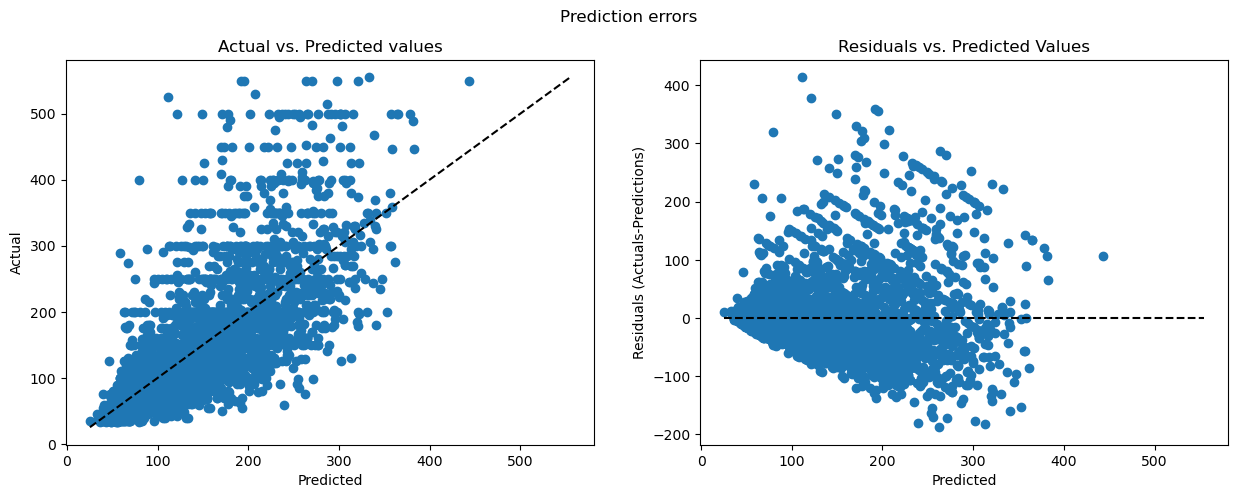

R²: 0.5675034231870559
MAE: 40.89373140363327
MSE: 3869.227834506519
RMSE: 62.203117562599054
MAPE: 0.316005849752657
error_ratio_rmse: 0.44973864822341775
error_ratio_mae: 0.295668323436892


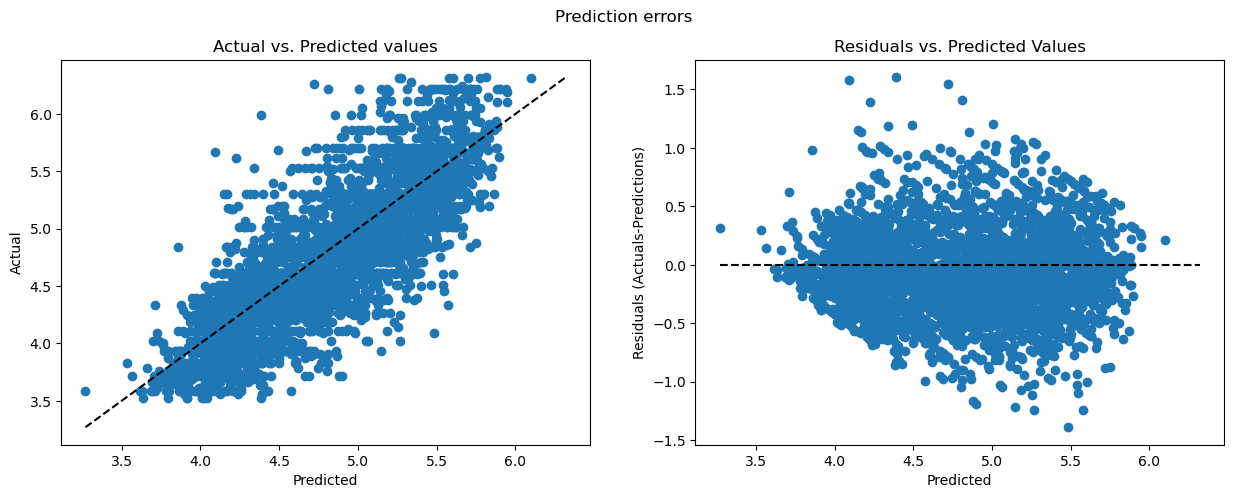

R²: 0.6572158241311186
MAE: 0.28559286120680083
MSE: 0.13321634369295504
RMSE: 0.3649881418525197
MAPE: 0.06131508992355026
error_ratio_rmse: 0.07703215428127841
error_ratio_mae: 0.06027547425089623


In [27]:
model_tuned = LGBMRegressor(
                          n_estimators =int(best_hyperparams['n_estimators']), 
                          max_depth = int(best_hyperparams['max_depth']), 
                          reg_alpha = best_hyperparams['reg_alpha'],
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=best_hyperparams['colsample_bytree'],
                          colsample_bynode=best_hyperparams['colsample_bynode'],
                          subsample=best_hyperparams['subsample'],
                          learning_rate=best_hyperparams['learning_rate'],
                          seed = int(best_hyperparams['seed']),
                          objective = 'regression',
                          metric='rmse'
                       )

#model_tuned.set_params(early_stopping_rounds=10)
model_tuned.fit(X_train_np, y_train_np,callbacks=None)

y_pred = np.maximum(0,model_tuned.predict(X_test_np))
model_tuned_score = scores(y_test_np,y_pred,plot=True)
model_tuned_logscore= scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

# Save Model

In [28]:
model_tuned.booster_.save_model('saved_models/lgbm_tuned.txt', )

with open('saved_models/lgbm_params.json', 'w') as f:
    json.dump(model_tuned.get_params(), f)
